In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

from anndata import AnnData

In [2]:
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

import pertpy as pt


# Toy data

In [66]:
def generate_toy_data_2(n_guides=2, n_cells_per_group=50):
    num_points = n_guides * n_cells_per_group
    # TODO: WIP right now, need to make this more general
    
    # guide1
    dats = []
    for i in range(n_guides):
        key = random.PRNGKey(i)
        key1, key2 = random.split(key)
        # Negative
        poisson_data = random.poisson(key1, lam=0.1, shape=num_points)
        # Positive
        gaussian_data = random.normal(key2, (num_points // n_guides,)) * 1.0 + 3
        gaussian_data = gaussian_data.clip(0.0, None)
        guide_data = jnp.concatenate([poisson_data[:(i*n_cells_per_group)], gaussian_data])
        dats.append(guide_data)
    
    # guide2
    key = random.PRNGKey(1)
    key1, key2 = random.split(key)
    # Poisson-distributed data (count data)
    poisson_data = random.poisson(key1, lam=0.1, shape=(2 * (num_points // 3),))
    # Gaussian-distributed data
    gaussian_data = random.normal(key2, (num_points // 3,)) * 1.0 + 3
    gaussian_data = gaussian_data.clip(0.0, None)
    guide2_data = jnp.concatenate([gaussian_data, poisson_data])
    
    # Combine Poisson and Gaussian data into one dataset
    exp_matrix = np.array(jnp.vstack([guide1_data, guide2_data])).T
    adata = AnnData(
        exp_matrix,
        obs=pd.DataFrame(index=[f"cell{i+1}" for i in range(exp_matrix.shape[0])]),
        var=pd.DataFrame(index=[f"guide{i+1}" for i in range(exp_matrix.shape[1])]),
    )
    adata.obs["ground_truth"] = ["guide2"] * (num_points // 3) + ["Negative"] * (num_points // 3) + ["guide1"] * (num_points // 3)
    return adata

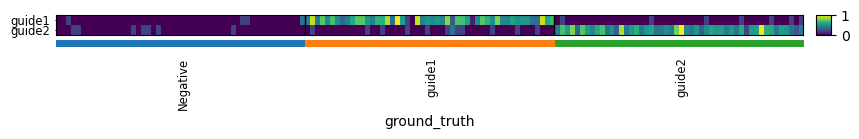

In [67]:
bdata = generate_toy_data_2()
# sc.pp.log1p(bdata)
sc.pl.heatmap(bdata, groupby="ground_truth", cmap="viridis", standard_scale="var", var_names=["guide1", "guide2"], swap_axes=True)

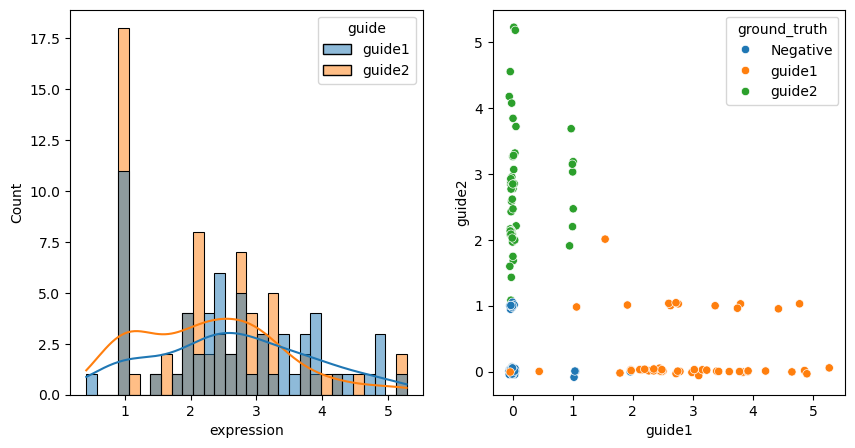

In [68]:
df = bdata.to_df().stack().reset_index().rename(columns={"level_0": "cell", "level_1": "guide", 0: "expression"})
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
df = df[df.expression > 0]
sns.histplot(df, x="expression", hue="guide", bins=30, kde=True, ax=axs[0])
df = bdata.to_df()
df = np.random.normal(0, 0.03, df.shape) + df
sns.scatterplot(data=df, x="guide1", y="guide2", hue=bdata.obs["ground_truth"], ax=axs[1])
plt.show()

In [57]:
ga = pt.pp.GuideAssignment()
ga.assign_mixture_model(bdata,
                        # fraction_positive_expected=0.05,
                        # poisson_rate_prior=0.1,
                        # gaussian_mean_prior=(4.0, 2),
                        # gaussian_std_prior=2.0
                        )

In [58]:
bdata.uns['guide_assignment_params']

{'gaussian_mean': Array(1.549954, dtype=float32),
 'gaussian_std': Array(0.44269356, dtype=float32),
 'mix_probs': Array([0.31638968, 0.6836102 ], dtype=float32),
 'poisson_rate': Array(0.40188766, dtype=float32)}

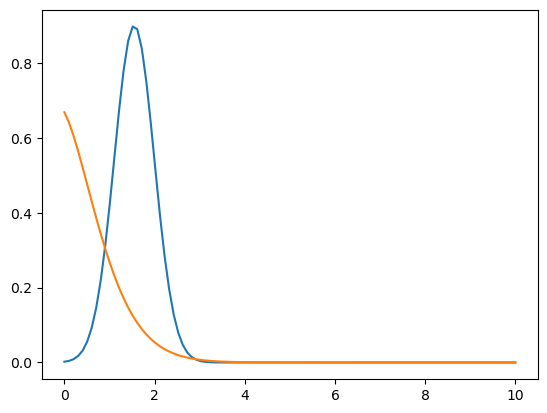

In [59]:
# plot probability distributions of model
# plot gaussian distribution
x = np.linspace(0, 10, 100)
y = dist.Normal(bdata.uns['guide_assignment_params']['gaussian_mean'],
                bdata.uns['guide_assignment_params']['gaussian_std']).log_prob(x)
plt.plot(x, np.exp(y))
# plot poisson distribution
x = np.linspace(0, 10, 100)
y = dist.Poisson(bdata.uns['guide_assignment_params']['poisson_rate']).log_prob(x)
plt.plot(x, np.exp(y))
plt.show()


In [60]:
bdata.obs.assigned_guide.value_counts()

assigned_guide
Negative    56
guide2      47
guide1      47
Name: count, dtype: int64

In [62]:
# evaluate accuracy
accuracy = accuracy_score(bdata.obs["ground_truth"], bdata.obs["assigned_guide"])
accuracy

0.94

# With real data

In [99]:
mdata = pt.data.papalexi_2021()
# seems like an error in the original data
from scipy.sparse import csr_matrix
mdata.mod["gdo"].X = csr_matrix(mdata.mod["gdo"].X.todense() - 1)
gdo = mdata.mod["gdo"]
gdo.layers["counts"] = gdo.X.copy()
# sc.pp.log1p(gdo)
gdo.var['guide_counts'] = gdo.X.sum(0).A1

subdata = gdo[:, gdo.var.index[:10]].copy()

/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push

In [ ]:
# TODO: I did something that made this ultra mega slow.
ga = pt.pp.GuideAssignment()
ga.assign_mixture_model(subdata, verbose=True, output_key="mixture_model_assignment")

Output()

In [20]:
subdata.obs.mixture_model_assignment[subdata.obs.mixture_model_assignment.str.contains("+", regex=False)]

index
l3_GAACCTACAAGTCTGT    CUL3g2+CMTM6g2
l6_GGCCGATCAAAGTCAA      CMTM6g1+NTg1
l6_TAAGTGCGTGACTACT      CMTM6g1+NTg3
l7_AACTCAGCAAGCGAGT       CUL3g1+NTg3
l7_AGAGCGAGTATAGGGC      CMTM6g3+NTg1
l7_CACAAACCATGCCCGA      CMTM6g1+NTg1
l8_TTCGGTCAGAACAACT       CUL3g1+NTg3
Name: mixture_model_assignment, dtype: object

In [21]:
ga.assign_to_max_guide(subdata, assignment_threshold=1, output_key='max_assignment')

# Calculate jaccard similarity between the two assignments
from sklearn.metrics import jaccard_score
jac = jaccard_score(subdata.obs['mixture_model_assignment'], subdata.obs['max_assignment'], average='weighted')
print(f"Jaccard similarity between max assignment and mixture assignment: {np.round(jac, 2)}")

Jaccard similarity between max assignment and mixture assignment: 0.89


/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


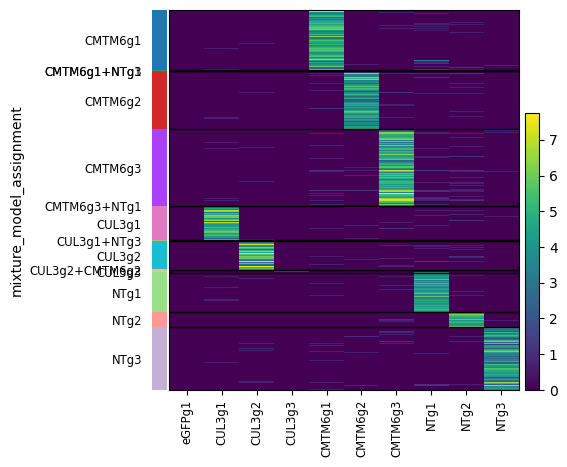

/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


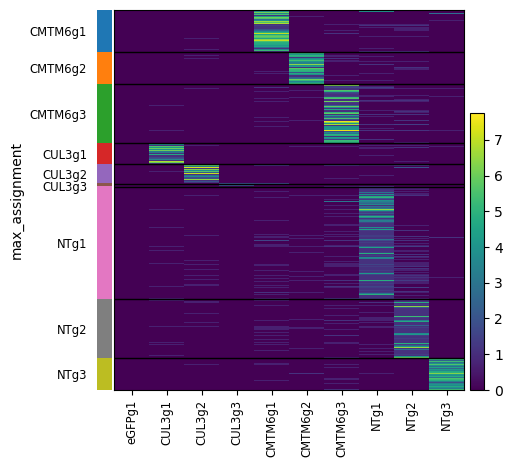

In [22]:
sc.pl.heatmap(subdata[subdata.obs.mixture_model_assignment!='Negative'], var_names=subdata.var.index, groupby='mixture_model_assignment', cmap='viridis', figsize=(5, 5))
sc.pl.heatmap(subdata[subdata.obs.max_assignment!='Negative'], var_names=subdata.var.index, groupby='max_assignment', cmap='viridis', figsize=(5, 5))

# In detail, single views

IFNGR1g2
IRF7g1
CD86g4
NTg4
IFNGR2g1


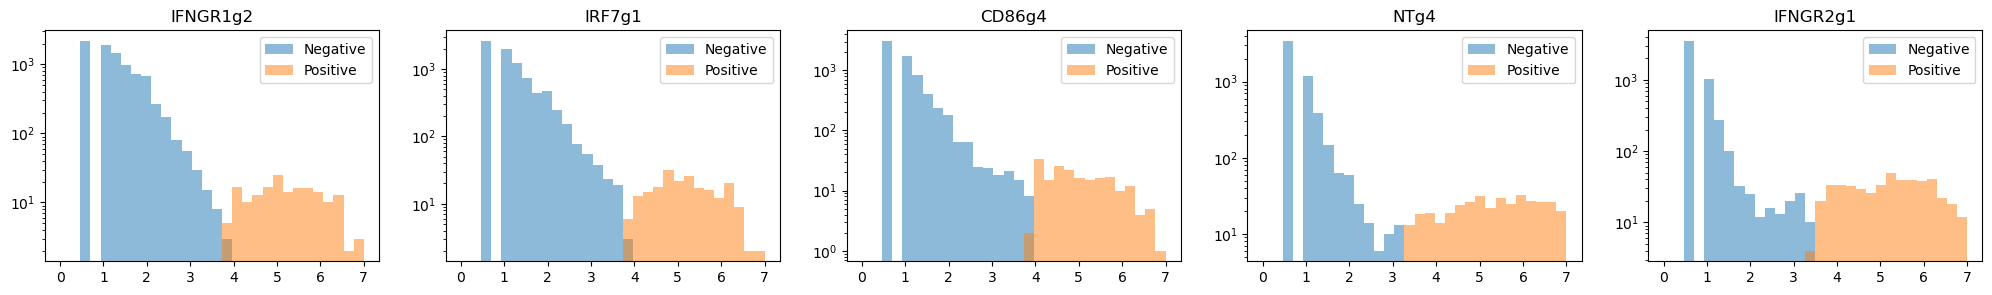

In [24]:
# Inspect for single guide expression distributions
guides = gdo.var.sort_values('guide_counts', ascending=False).index[:5]
fig, axs = plt.subplots(1, len(guides), figsize=(5*len(guides), 3))

from pertpy.preprocessing._guide_rna_mixture import Poisson_Gauss_Mixture
for guide, ax in zip(guides, axs):
    print(guide)
    data = gdo[:, guide].X.todense().A1

    mixture_model = Poisson_Gauss_Mixture()
    is_nonzero = data!=0
    data_nonzero = data[is_nonzero]
    assignments = mixture_model.run_model(data_nonzero)

    gdo.obs['guide_assignment'] = 'Negative'
    gdo.obs.loc[gdo.obs_names[is_nonzero], 'guide_assignment'] = assignments
    
    ax.hist(data_nonzero[assignments == 'Negative'], bins=30, range=(0,7), alpha=0.5, label="Negative")
    ax.hist(data_nonzero[assignments == 'Positive'], bins=30, range=(0,7), alpha=0.5, label="Positive")
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(guide)
plt.show()